# Introduction

The dataset for this competition (both train and test) was generated from a deep learning model trained on a [Employee Attrition](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset). Feature distributions are close to, but not exactly the same, as the original.

For each `EmployeeNumber` in the test set, you must predict the probability for the target variable `Attrition`.

## About Dataset

* `Age`                     
* `BusinessTravel`          
* `DailyRate`               
* `Department`              
* `DistanceFromHome`        
* `Education`               
* `EducationField`          
* `EmployeeCount`           
* `EnvironmentSatisfaction` 
* `Gender`                  
* `HourlyRate`              
* `JobInvolvement`          
* `JobLevel`                
* `JobRole`                 
* `JobSatisfaction`         
* `MaritalStatus`           
* `MonthlyIncome`           
* `MonthlyRate`             
* `NumCompaniesWorked`      
* `Over18`                  
* `OverTime`                
* `PercentSalaryHike`       
* `PerformanceRating`       
* `RelationshipSatisfaction`
* `StandardHours`           
* `StockOptionLevel`        
* `TotalWorkingYears`       
* `TrainingTimesLastYear`   
* `WorkLifeBalance`         
* `YearsAtCompany`          
* `YearsInCurrentRole`      
* `YearsSinceLastPromotion` 
* `YearsWithCurrManager`    
* `Attrition` 

Submissions are evaluated on **area under the ROC** curve between the predicted probability and the observed target.

# Library Import
* Some library import and some configurations of seaborn.

In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mlens

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlens.ensemble import SuperLearner

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
#from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

#from category_encoders import WOEEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna

import xgboost as xgb
import lightgbm as lgbm
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
#from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from numpy import hstack
from numpy import vstack
from numpy import asarray
from mlens.ensemble import SuperLearner

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')

[MLENS] backend: threading


# Data

In [2]:
traindf = pd.read_csv('https://raw.githubusercontent.com/Thinayani/ER-Sys/main/train.csv')
testdf = pd.read_csv('https://raw.githubusercontent.com/Thinayani/ER-Sys/main/test.csv')

In [3]:
print('Train shape: ', traindf.shape)
print('Test shape : ', testdf.shape)

Train shape:  (1677, 35)
Test shape :  (1119, 35)


In [4]:
traindf.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [5]:
testdf.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,1677,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,...,80,0,1,2,2,1,0,0,0,0.188407
1,1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,...,80,1,7,3,3,2,2,2,2,0.137034
2,1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,...,80,2,13,2,2,7,7,1,7,0.044329
3,1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,...,80,0,14,2,2,14,10,11,8,0.061096
4,1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,...,80,0,1,5,3,1,0,0,0,0.512708


In [6]:
hehe_df = pd.concat([traindf, testdf], axis=0)

# **Data Preprocessing**

## Missing Data
* There are no missing values!

In [7]:
# checking for null values
pd.concat([traindf.isnull().sum().rename("Missing in Train"),
           testdf.isnull().sum().rename("Missing in Test")], axis=1).sort_values(by="Missing in Train")

,Missing in Train,Missing in Test
id,0,0
NumCompaniesWorked,0,0
Over18,0,0
OverTime,0,0
PercentSalaryHike,0,0
PerformanceRating,0,0
RelationshipSatisfaction,0,0
MonthlyRate,0,0
StandardHours,0,0
TotalWorkingYears,0,0


In [8]:
def testDataframe(test_df):
    test_df['Attrition'] = test_df['Attrition'].apply(lambda x: 1 if x >= 0.5 else 0 if x <= 0.4 else x)
    test_df.Attrition = test_df.Attrition.astype(int)
    
    return test_df

In [9]:
testdf = testDataframe(testdf)

# Categorical Features

### Numerical Features
* `EmployeeCount` , `StandardHours` and `Over18` are constant.

In [10]:
def DropFeatures(dataframe):
    feats_to_drop = [col for col in dataframe.columns if dataframe[col].nunique()==1]
    cat_features = [col for col in dataframe.columns if dataframe[col].nunique() <= 20 and dataframe[col].nunique() > 1]
    dataframe.drop(columns=feats_to_drop, inplace=True)
    
    ord_enc = OrdinalEncoder()
    ord_enc.fit(dataframe[cat_features])
    dataframe[cat_features] = ord_enc.transform(dataframe[cat_features])
    
    return dataframe

## Construct New Features

In [11]:
def CreateNewFeatures(dataframe):
    dataframe['MonthlyIncome/Age'] = dataframe['MonthlyIncome'] / dataframe['Age']

    dataframe["Age_risk"] = (dataframe["Age"] < 34).astype(int)
    dataframe["HourlyRate_risk"] = (dataframe["HourlyRate"] < 60).astype(int)
    dataframe["Distance_risk"] = (dataframe["DistanceFromHome"] >= 20).astype(int)
    dataframe["YearsAtCo_risk"] = (dataframe["YearsAtCompany"] < 4).astype(int)

    dataframe['NumCompaniesWorked'] = dataframe['NumCompaniesWorked'].replace(0, 1)
    dataframe['AverageTenure'] = dataframe["TotalWorkingYears"] / dataframe["NumCompaniesWorked"]

    dataframe['JobHopper'] = ((dataframe["NumCompaniesWorked"] > 2) & (dataframe["AverageTenure"] < 2.0)).astype(int)

    #df["AttritionRisk"] = df["Age_risk"] + df["HourlyRate_risk"] + df["Distance_risk"] + df["YearsAtCo_risk"] + df['JobHopper']

    
    
    dataframe['feature_1'] = np.where(((dataframe['StockOptionLevel'] >= 1) & 
                                (dataframe['YearsAtCompany'] >= 3) & 
                                (dataframe['YearsWithCurrManager'] >= 1)), 1, 0)
    
    return dataframe

# Feature Selection

In [12]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [13]:
def Preprocessing(dataframe):
    dataframe = DropFeatures(dataframe)
    dataframe = CreateNewFeatures(dataframe)
    corr_features = correlation(dataframe, 0.78)
    
    dataframe = dataframe.drop(columns=['id', 'Distance_risk', 'HourlyRate_risk', 'MonthlyIncome', 'MonthlyIncome/Age', 'YearsInCurrentRole', 'YearsWithCurrManager'])
    dataframe.Attrition = dataframe.Attrition.astype(int)

    cols_to_scale = ["Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyRate", "PercentSalaryHike", "TotalWorkingYears", "YearsAtCompany", "AverageTenure", "YearsSinceLastPromotion"]
    scaler = StandardScaler()
    dataframe[cols_to_scale] = scaler.fit_transform(dataframe[cols_to_scale])
    
    return dataframe

In [14]:
df = pd.concat([traindf, testdf], axis=0)

In [15]:
for column in df:
    print(f'{column}: {df[column].unique()}')

id: [   0    1    2 ... 2793 2794 2795]
Age: [36 35 32 38 50 27 34 40 51 25 29 48 26 39 33 52 42 30 43 24 41 47 31 56
 44 28 46 18 45 37 49 53 54 23 59 22 55 20 57 19 21 58 60]
BusinessTravel: ['Travel_Frequently' 'Travel_Rarely' 'Non-Travel']
DailyRate: [ 599  921  718 1488 1017  566  944 1009 1297  806  885  694  138 1287
  884  640  894  607 1495 1092 1392 1082 1107  530  746 1005  796  228
 1358  959 1276 1349  154 1277  979  300  555  874 1443  933  833 1001
  469 1217  301  119 1469  994  932  809 1179 1434  869 1198 1427 1383
  528  548 1097 1413  322  319 1401  477  999 1223  769 1339  523 1003
 1018  672 1099 1396  465 1333  604 1206 1313 1275  653 1219 1336  144
 1137 1063 1403  942  723  571  442 1303 1450  857  807  682  790 1332
 1168  598 1142  920  691  882  895  464  658  954  715  853 1136 1283
 1448  804  546  775 1319 1146  359  383  821 1323  543 1288 1479  350
  603  835  489  750  462  426  688  466 1311 1377  991  713 1211  304
 1362  783  575  641  689 1302  136

In [16]:
df = Preprocessing(df)

In [17]:
for column in df:
    print(f'{column}: {df[column].unique()}')

Age: [-0.00942186 -0.12547263 -0.47362495  0.22267968  1.61528896 -1.05387882
 -0.24152341  0.45478123  1.73133973 -1.28598036 -0.82177727  1.38318741
 -1.16992959  0.33873046 -0.35757418  1.8473905   0.68688277 -0.7057265
  0.80293355 -1.40203113  0.570832    1.26713664 -0.58967573  2.31159359
  0.91898432 -0.93782804  1.15108587 -2.09833577  1.03503509  0.10662891
  1.49923818  1.96344127  2.07949205 -1.51808191  2.65974591 -1.63413268
  2.19554282 -1.86623422  2.42764436 -1.982285   -1.75018345  2.54369514
  2.77579668]
BusinessTravel: [1. 2. 0.]
DailyRate: [-7.81468675e-01  8.60277502e-02 -4.60872170e-01  1.61357580e+00
  3.44660225e-01 -8.70373588e-01  1.47991781e-01  3.23107519e-01
  1.09900494e+00 -2.23792402e-01 -1.09594278e-02 -5.25530289e-01
 -2.02344337e+00  1.07206406e+00 -1.36535161e-02 -6.71011056e-01
  1.32873667e-02 -7.59915969e-01  1.63243442e+00  5.46716846e-01
  1.35494333e+00  5.19775963e-01  5.87128170e-01 -9.67360766e-01
 -3.85437698e-01  3.12331166e-01 -2.5073328

In [18]:
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,Attrition,Age_risk,YearsAtCo_risk,AverageTenure,JobHopper,feature_1
0,-0.009422,1.0,-0.781469,1.0,1.963961,2.0,3.0,4.0,1.0,-1.334933,...,2.0,2.0,0.525264,1.586671,0,0,0,0.698238,0,1
1,-0.125473,2.0,0.086028,2.0,-0.086825,2.0,4.0,1.0,1.0,-1.129318,...,3.0,2.0,-0.488405,-0.642642,0,0,0,-0.389082,0,1
2,-0.473625,2.0,-0.460872,2.0,2.220309,2.0,2.0,3.0,1.0,0.618407,...,3.0,2.0,-0.657350,-0.324168,0,1,1,-0.389082,0,1
3,0.222680,2.0,1.613576,1.0,-0.855869,2.0,3.0,3.0,0.0,-1.437740,...,1.0,0.0,-0.150516,-0.642642,0,0,0,-0.207862,0,0
4,1.615289,2.0,0.344660,1.0,-0.471347,3.0,3.0,2.0,0.0,-1.591951,...,0.0,2.0,4.073104,0.631251,1,0,0,4.503862,0,0


In [19]:
for cols in df.columns:
    print('"'+ cols + '",')

"Age",
"BusinessTravel",
"DailyRate",
"Department",
"DistanceFromHome",
"Education",
"EducationField",
"EnvironmentSatisfaction",
"Gender",
"HourlyRate",
"JobInvolvement",
"JobLevel",
"JobRole",
"JobSatisfaction",
"MaritalStatus",
"MonthlyRate",
"NumCompaniesWorked",
"OverTime",
"PercentSalaryHike",
"PerformanceRating",
"RelationshipSatisfaction",
"StockOptionLevel",
"TotalWorkingYears",
"TrainingTimesLastYear",
"WorkLifeBalance",
"YearsAtCompany",
"YearsSinceLastPromotion",
"Attrition",
"Age_risk",
"YearsAtCo_risk",
"AverageTenure",
"JobHopper",
"feature_1",


# Split Data

In [20]:
X = df.drop(columns=['Attrition'], axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# import imblearn
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import RandomOverSampler

# # perform random undersampling
# ran_ov_sam = RandomOverSampler(random_state=42)
# X_train, y_train = ran_ov_sam.fit_resample(X_train, y_train)

# # print the class distribution after undersampling
# print('Resampled class distribution:', Counter(y_train))

In [22]:
X_test

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,Age_risk,YearsAtCo_risk,AverageTenure,JobHopper,feature_1
1025,-0.125473,2.0,0.164156,2.0,-0.214999,1.0,2.0,4.0,1.0,-0.306859,...,-0.096527,5.0,1.0,0.525264,1.586671,0,0,0.698238,0,1
730,0.106629,2.0,-0.622517,2.0,-0.727695,2.0,1.0,1.0,1.0,-1.077914,...,-0.096527,3.0,2.0,0.525264,-0.642642,0,0,0.698238,0,1
450,0.338730,2.0,-1.236770,1.0,-0.214999,3.0,3.0,1.0,1.0,-0.409667,...,-0.510254,3.0,2.0,-0.995239,-0.642642,0,1,-0.932743,1,0
918,0.686883,2.0,-0.649458,1.0,-0.984043,2.0,1.0,2.0,1.0,0.207177,...,-0.372345,3.0,2.0,-0.657350,-0.324168,0,1,-0.751523,0,0
439,-0.937828,2.0,1.115169,1.0,1.963961,2.0,3.0,3.0,1.0,-0.975107,...,-0.648163,3.0,2.0,-0.150516,-0.324168,1,0,-0.026642,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,-0.357574,2.0,-0.778775,0.0,-0.471347,1.0,1.0,2.0,0.0,-0.306859,...,-0.096527,2.0,2.0,0.525264,1.905145,1,0,0.698238,0,0
559,-0.589676,2.0,1.379190,2.0,2.604831,2.0,4.0,3.0,0.0,1.235251,...,1.696293,2.0,2.0,-0.657350,-0.324168,1,1,0.275391,0,1
461,0.338730,1.0,0.393154,1.0,-0.343173,4.0,3.0,2.0,1.0,1.183847,...,-0.648163,2.0,1.0,-0.319460,-0.642642,0,0,-0.026642,0,1
1582,-0.009422,1.0,0.681421,2.0,0.169524,2.0,1.0,3.0,1.0,0.567003,...,-0.096527,3.0,2.0,0.356319,1.905145,0,0,0.698238,0,0


# Scale Features

In [23]:
y_train

284     0
1465    0
879     0
238     0
1641    0
       ..
1638    1
1095    0
1130    0
1294    0
860     0
Name: Attrition, Length: 2236, dtype: int32

In [24]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [25]:
X_train

array([[ 0.68688277,  2.        , -0.60635294, ..., -0.79682786,
         1.        ,  0.        ],
       [-0.12547263,  2.        , -0.16182837, ...,  0.51701833,
         0.        ,  0.        ],
       [-0.00942186,  2.        , -0.30730914, ..., -0.78776686,
         1.        ,  1.        ],
       ...,
       [-0.12547263,  2.        , -0.82188   , ...,  0.6982385 ,
         0.        ,  0.        ],
       [-0.58967573,  2.        ,  0.51977596, ..., -0.38908249,
         0.        ,  1.        ],
       [-0.00942186,  0.        , -0.09178208, ...,  0.6982385 ,
         0.        ,  1.        ]])

In [26]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
print('Train shape: ', X_train.shape)
print('Test shape : ', y_train.shape)

Train shape:  (2236, 32)
Test shape :  (2236,)


# Cross-Validation

In [28]:
def cross_validate(X, y, model):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_scores = []
    
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        
        auc = roc_auc_score(y_val, y_pred)
        
        print(f"Fold {fold_id} \t auc: {auc}")
        
        all_scores.append(auc)
    
    avg_auc = np.mean(all_scores)
    
    print(f"Avg AUC: {avg_auc}")

# **Hyperparameter Optimization**

# XGBoost Classifier

In [29]:
from sklearn.metrics import recall_score

# random params values 
xgb_params = {'n_estimators': 150,
                 'max_depth': 3,
                 'learning_rate': 0.1,
                 'min_child_weight': 4,
                 'subsample': 0.7,
                 'colsample_bytree': 0.3
             }


xgb_clf = xgb.XGBClassifier(**xgb_params)
cross_validate(X_train, y_train, xgb_clf)
xgb_clf.fit(X_train, y_train, verbose=0)

Fold 0 	 auc: 0.8347393467445382
Fold 1 	 auc: 0.8503136491455764
Fold 2 	 auc: 0.8788665368808133
Fold 3 	 auc: 0.8602638979017954
Fold 4 	 auc: 0.890114644170452
Fold 5 	 auc: 0.9119619294830197
Fold 6 	 auc: 0.9314789687924017
Fold 7 	 auc: 0.8790140208050656
Fold 8 	 auc: 0.9170058796924468
Fold 9 	 auc: 0.8824061510628675
Avg AUC: 0.8836165024678977


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [30]:
def objective(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }

    xgb_clf = xgb.XGBClassifier(**xgb_params)

    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_scores = []
    all_recalls = []

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        xgb_clf.fit(X_tr, y_tr)

        y_pred = xgb_clf.predict_proba(X_val)[:, 1]
        #y_pred = (model.predict_proba(X_val)[:, 1] > 0.5).astype(int)
        #y_pred = (model.predict_proba(X_val) > 0.5).astype(int)

        auc = roc_auc_score(y_val, y_pred)
        #recall_value = recall_score(y_val, y_pred)
        
        all_scores.append(auc)
        #all_recalls.append(recall_value)
        
    avg_auc = np.mean(all_scores)
    #avg_recall = np.mean(all_recalls)
    
    return avg_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Avg_roc_auc_score: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
xgb_clf = xgb.XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train, verbose=0)

[I 2023-05-07 10:56:25,706] A new study created in memory with name: no-name-cfe94f95-a94c-4f88-af8e-67742a6aee17
[I 2023-05-07 10:56:27,836] Trial 0 finished with value: 0.8684728531256759 and parameters: {'n_estimators': 403, 'max_depth': 5, 'learning_rate': 0.09573388076085863, 'min_child_weight': 6, 'subsample': 0.33720107982559144, 'colsample_bytree': 0.11531414918397109}. Best is trial 0 with value: 0.8684728531256759.
[I 2023-05-07 10:56:28,608] Trial 1 finished with value: 0.8696802548522211 and parameters: {'n_estimators': 94, 'max_depth': 4, 'learning_rate': 0.02818327431771408, 'min_child_weight': 1, 'subsample': 0.4370181312620214, 'colsample_bytree': 0.4487825808721303}. Best is trial 1 with value: 0.8696802548522211.
[I 2023-05-07 10:56:31,749] Trial 2 finished with value: 0.8701276227557863 and parameters: {'n_estimators': 384, 'max_depth': 10, 'learning_rate': 0.03760393374337876, 'min_child_weight': 2, 'subsample': 0.2324076093787441, 'colsample_bytree': 0.872059947402

Best trial:
  Avg_roc_auc_score: 0.8732159361296284
  Params: 
    n_estimators: 477
    max_depth: 3
    learning_rate: 0.0654363375130975
    min_child_weight: 3
    subsample: 0.8813174520068222
    colsample_bytree: 0.8244174249657894


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8244174249657894, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0654363375130975,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=477, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [31]:
xgb_pred = xgb_clf.predict(X_test)

print("Accuracy_value: ", accuracy_score(y_test, xgb_pred))
print("f1_score_value: ", f1_score(y_test, xgb_pred))
print("recall_value: ", recall_score(y_test, xgb_pred))
print("roc_auc_score: ", roc_auc_score(y_test, xgb_pred))

Accuracy_value:  0.9392857142857143
f1_score_value:  0.5641025641025641
recall_value:  0.44
roc_auc_score:  0.7141176470588235


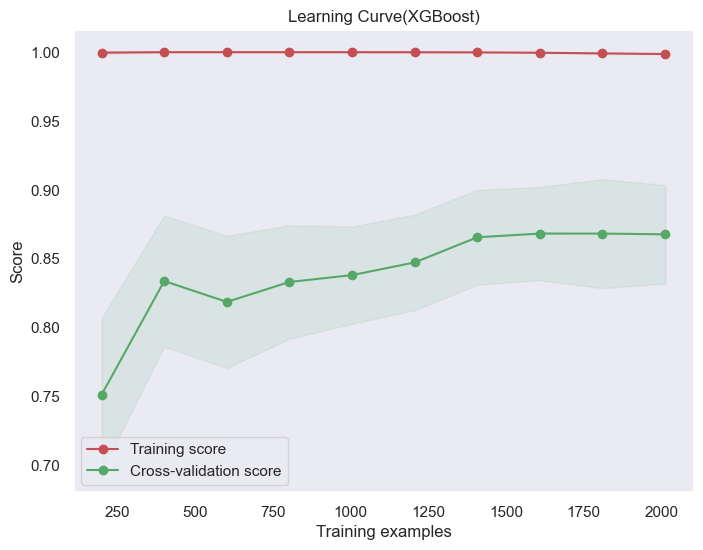

In [69]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve(XGBoost)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [33]:
from joblib import dump

# Save the trained model to a file
dump(xgb_clf, 'xgb_model.joblib')

['xgb_model.joblib']

# LightGBM Classifier

In [34]:
# random params 
lgbm_params = {'n_estimators': 407,
                 'num_rounds': 274,
                 'learning_rate': 0.1,
                 'num_leaves': 195,
                 'max_depth': 9,
                 'min_data_in_leaf': 46,
                 'lambda_l1': 0.01,
                 'lambda_l2': 0.6,
                 'min_gain_to_split': 1.42,
                 'bagging_fraction': 0.45,
                 'feature_fraction': 0.3}

lgbm_clf = lgbm.LGBMClassifier(**lgbm_params)
cross_validate(X_train, y_train, lgbm_clf)
lgbm_clf.fit(X_train, y_train, verbose=False)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=1.42, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.42
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] num_iterations is set=274, num_rounds=274 will be ignored. Current value: num_iterations=274
Fold 0 	 auc: 0.8386329223447977
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data

LGBMClassifier(bagging_fraction=0.45, feature_fraction=0.3, lambda_l1=0.01,
               lambda_l2=0.6, max_depth=9, min_data_in_leaf=46,
               min_gain_to_split=1.42, n_estimators=407, num_leaves=195,
               num_rounds=274)

In [35]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_rounds': trial.suggest_int('num_rounds', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'random_state': 1337
    }

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_scores = []
    all_recalls = []

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = lgbm.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)

        y_pred = model.predict_proba(X_val)[:, 1]
        #y_pred = (model.predict_proba(X_val)[:, 1] > 0.5).astype(int)

        auc = roc_auc_score(y_val, y_pred)
        #recall_value = recall_score(y_val, y_pred)

        all_scores.append(auc)
        #all_recalls.append(recall_value)

    avg_auc = np.mean(all_scores)
    #avg_recall = np.mean(all_recalls)

    return avg_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Avg_roc_auc_score: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
lgbm_clf = lgbm.LGBMClassifier(**best_params)
lgbm_clf.fit(X_train, y_train, verbose=False)

[I 2023-05-07 10:56:58,254] A new study created in memory with name: no-name-de30c595-8167-40da-aa5c-25e3b26ae652


[LightGBM] [Warning] feature_fraction is set=0.7187161451941976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7187161451941976
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_gain_to_split is set=9.697227907056527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.697227907056527
[LightGBM] [Warning] bagging_fraction is set=0.9547763441001976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9547763441001976
[LightGBM] [Warning] lambda_l1 is set=8.031673669634623e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.031673669634623e-08
[LightGBM] [Warning] lambda_l2 is set=0.744641056723674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.744641056723674
[LightGBM] [Warning] num_iterations is set=259, num_rounds=259 will be ignored. Current value: num_iterations=259
[LightGBM] [Warning] feature_fraction is

[I 2023-05-07 10:56:58,932] Trial 0 finished with value: 0.841786128645311 and parameters: {'n_estimators': 636, 'num_rounds': 259, 'learning_rate': 0.0011338998346861614, 'num_leaves': 108, 'max_depth': 8, 'min_data_in_leaf': 90, 'lambda_l1': 8.031673669634623e-08, 'lambda_l2': 0.744641056723674, 'min_gain_to_split': 9.697227907056527, 'bagging_fraction': 0.9547763441001976, 'feature_fraction': 0.7187161451941976}. Best is trial 0 with value: 0.841786128645311.


[LightGBM] [Warning] feature_fraction is set=0.7187161451941976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7187161451941976
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_gain_to_split is set=9.697227907056527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.697227907056527
[LightGBM] [Warning] bagging_fraction is set=0.9547763441001976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9547763441001976
[LightGBM] [Warning] lambda_l1 is set=8.031673669634623e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.031673669634623e-08
[LightGBM] [Warning] lambda_l2 is set=0.744641056723674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.744641056723674
[LightGBM] [Warning] num_iterations is set=259, num_rounds=259 will be ignored. Current value: num_iterations=259
[LightGBM] [Warning] feature_fraction is

[I 2023-05-07 10:56:59,318] Trial 1 finished with value: 0.8638408746779934 and parameters: {'n_estimators': 948, 'num_rounds': 196, 'learning_rate': 0.03787530937466169, 'num_leaves': 267, 'max_depth': 15, 'min_data_in_leaf': 66, 'lambda_l1': 1.1045991326327589, 'lambda_l2': 0.029125532554914256, 'min_gain_to_split': 3.899840862062166, 'bagging_fraction': 0.6292667997817168, 'feature_fraction': 0.9109383403621444}. Best is trial 1 with value: 0.8638408746779934.


[LightGBM] [Warning] feature_fraction is set=0.47716952750806685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47716952750806685
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=2.3766174235141015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3766174235141015
[LightGBM] [Warning] bagging_fraction is set=0.9461296237182815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9461296237182815
[LightGBM] [Warning] lambda_l1 is set=1.49819501688445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.49819501688445
[LightGBM] [Warning] lambda_l2 is set=0.0009611731204356844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009611731204356844
[LightGBM] [Warning] num_iterations is set=979, num_rounds=979 will be ignored. Current value: num_iterations=979
[LightGBM] [Warning] feature_fraction 

[I 2023-05-07 10:57:00,563] Trial 2 finished with value: 0.8697800523076318 and parameters: {'n_estimators': 120, 'num_rounds': 979, 'learning_rate': 0.0584666499581536, 'num_leaves': 375, 'max_depth': 13, 'min_data_in_leaf': 28, 'lambda_l1': 1.49819501688445, 'lambda_l2': 0.0009611731204356844, 'min_gain_to_split': 2.3766174235141015, 'bagging_fraction': 0.9461296237182815, 'feature_fraction': 0.47716952750806685}. Best is trial 2 with value: 0.8697800523076318.


[LightGBM] [Warning] feature_fraction is set=0.8314013095442243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8314013095442243
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=3.793844011565821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.793844011565821
[LightGBM] [Warning] bagging_fraction is set=0.7916007384558362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916007384558362
[LightGBM] [Warning] lambda_l1 is set=4.8383326723072514e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8383326723072514e-05
[LightGBM] [Warning] lambda_l2 is set=0.7386819381577258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7386819381577258
[LightGBM] [Warning] num_iterations is set=811, num_rounds=811 will be ignored. Current value: num_iterations=811
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.8314013095442243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8314013095442243
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=3.793844011565821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.793844011565821
[LightGBM] [Warning] bagging_fraction is set=0.7916007384558362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916007384558362
[LightGBM] [Warning] lambda_l1 is set=4.8383326723072514e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8383326723072514e-05
[LightGBM] [Warning] lambda_l2 is set=0.7386819381577258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7386819381577258
[LightGBM] [Warning] num_iterations is set=811, num_rounds=811 will be ignored. Current value: num_iterations=811


[I 2023-05-07 10:57:03,474] Trial 3 finished with value: 0.8613493795842919 and parameters: {'n_estimators': 981, 'num_rounds': 811, 'learning_rate': 0.002314500791446639, 'num_leaves': 20, 'max_depth': 11, 'min_data_in_leaf': 20, 'lambda_l1': 4.8383326723072514e-05, 'lambda_l2': 0.7386819381577258, 'min_gain_to_split': 3.793844011565821, 'bagging_fraction': 0.7916007384558362, 'feature_fraction': 0.8314013095442243}. Best is trial 2 with value: 0.8697800523076318.


[LightGBM] [Warning] feature_fraction is set=0.1904417295600937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1904417295600937
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_gain_to_split is set=2.5481406108781, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5481406108781
[LightGBM] [Warning] bagging_fraction is set=0.8134600766719878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8134600766719878
[LightGBM] [Warning] lambda_l1 is set=1.0795711971901716e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0795711971901716e-06
[LightGBM] [Warning] lambda_l2 is set=1.7702130221827277e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7702130221827277e-06
[LightGBM] [Warning] num_iterations is set=577, num_rounds=577 will be ignored. Current value: num_iterations=577
[LightGBM] [Warning] feature_fra

[I 2023-05-07 10:57:05,244] Trial 4 finished with value: 0.8632843686704815 and parameters: {'n_estimators': 365, 'num_rounds': 577, 'learning_rate': 0.0030511348822672875, 'num_leaves': 476, 'max_depth': 10, 'min_data_in_leaf': 69, 'lambda_l1': 1.0795711971901716e-06, 'lambda_l2': 1.7702130221827277e-06, 'min_gain_to_split': 2.5481406108781, 'bagging_fraction': 0.8134600766719878, 'feature_fraction': 0.1904417295600937}. Best is trial 2 with value: 0.8697800523076318.


[LightGBM] [Warning] feature_fraction is set=0.6233361523376112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6233361523376112
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=0.4313098900324275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4313098900324275
[LightGBM] [Warning] bagging_fraction is set=0.49605080522094824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49605080522094824
[LightGBM] [Warning] lambda_l1 is set=8.156843216708114e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.156843216708114e-07
[LightGBM] [Warning] lambda_l2 is set=0.0033313237315198375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033313237315198375
[LightGBM] [Warning] num_iterations is set=468, num_rounds=468 will be ignored. Current value: num_iterations=468
[LightGBM] [Warning] feature

[LightGBM] [Warning] feature_fraction is set=0.6233361523376112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6233361523376112
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=0.4313098900324275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4313098900324275
[LightGBM] [Warning] bagging_fraction is set=0.49605080522094824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49605080522094824
[LightGBM] [Warning] lambda_l1 is set=8.156843216708114e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.156843216708114e-07
[LightGBM] [Warning] lambda_l2 is set=0.0033313237315198375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033313237315198375
[LightGBM] [Warning] num_iterations is set=468, num_rounds=468 will be ignored. Current value: num_iterations=468


[I 2023-05-07 10:57:07,944] Trial 5 finished with value: 0.859727056417517 and parameters: {'n_estimators': 778, 'num_rounds': 468, 'learning_rate': 0.0016099196088321264, 'num_leaves': 117, 'max_depth': 5, 'min_data_in_leaf': 14, 'lambda_l1': 8.156843216708114e-07, 'lambda_l2': 0.0033313237315198375, 'min_gain_to_split': 0.4313098900324275, 'bagging_fraction': 0.49605080522094824, 'feature_fraction': 0.6233361523376112}. Best is trial 2 with value: 0.8697800523076318.


[LightGBM] [Warning] feature_fraction is set=0.7503662867531303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7503662867531303
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_gain_to_split is set=4.944053272523419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.944053272523419
[LightGBM] [Warning] bagging_fraction is set=0.5077841653465035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5077841653465035
[LightGBM] [Warning] lambda_l1 is set=9.13042068750366e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.13042068750366e-05
[LightGBM] [Warning] lambda_l2 is set=2.008634542852945e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.008634542852945e-06
[LightGBM] [Warning] num_iterations is set=887, num_rounds=887 will be ignored. Current value: num_iterations=887
[LightGBM] [Warning] feature_fract

[LightGBM] [Warning] feature_fraction is set=0.7503662867531303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7503662867531303
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_gain_to_split is set=4.944053272523419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.944053272523419
[LightGBM] [Warning] bagging_fraction is set=0.5077841653465035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5077841653465035
[LightGBM] [Warning] lambda_l1 is set=9.13042068750366e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.13042068750366e-05
[LightGBM] [Warning] lambda_l2 is set=2.008634542852945e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.008634542852945e-06
[LightGBM] [Warning] num_iterations is set=887, num_rounds=887 will be ignored. Current value: num_iterations=887


[I 2023-05-07 10:57:10,547] Trial 6 finished with value: 0.8556043891215858 and parameters: {'n_estimators': 403, 'num_rounds': 887, 'learning_rate': 0.001681205722754157, 'num_leaves': 271, 'max_depth': 10, 'min_data_in_leaf': 79, 'lambda_l1': 9.13042068750366e-05, 'lambda_l2': 2.008634542852945e-06, 'min_gain_to_split': 4.944053272523419, 'bagging_fraction': 0.5077841653465035, 'feature_fraction': 0.7503662867531303}. Best is trial 2 with value: 0.8697800523076318.


[LightGBM] [Warning] feature_fraction is set=0.7282141325645685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7282141325645685
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_gain_to_split is set=2.976984599879482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.976984599879482
[LightGBM] [Warning] bagging_fraction is set=0.7907263759437492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7907263759437492
[LightGBM] [Warning] lambda_l1 is set=8.282440010720995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.282440010720995
[LightGBM] [Warning] lambda_l2 is set=0.0001369660193686484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001369660193686484
[LightGBM] [Warning] num_iterations is set=473, num_rounds=473 will be ignored. Current value: num_iterations=473
[LightGBM] [Warning] feature_fraction is

[I 2023-05-07 10:57:11,078] Trial 7 finished with value: 0.8530317778695456 and parameters: {'n_estimators': 204, 'num_rounds': 473, 'learning_rate': 0.07005769585897134, 'num_leaves': 144, 'max_depth': 6, 'min_data_in_leaf': 95, 'lambda_l1': 8.282440010720995, 'lambda_l2': 0.0001369660193686484, 'min_gain_to_split': 2.976984599879482, 'bagging_fraction': 0.7907263759437492, 'feature_fraction': 0.7282141325645685}. Best is trial 2 with value: 0.8697800523076318.


[LightGBM] [Warning] feature_fraction is set=0.7282141325645685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7282141325645685
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_gain_to_split is set=2.976984599879482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.976984599879482
[LightGBM] [Warning] bagging_fraction is set=0.7907263759437492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7907263759437492
[LightGBM] [Warning] lambda_l1 is set=8.282440010720995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.282440010720995
[LightGBM] [Warning] lambda_l2 is set=0.0001369660193686484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001369660193686484
[LightGBM] [Warning] num_iterations is set=473, num_rounds=473 will be ignored. Current value: num_iterations=473
[LightGBM] [Warning] feature_fraction is

[I 2023-05-07 10:57:12,038] Trial 8 finished with value: 0.857651465990207 and parameters: {'n_estimators': 515, 'num_rounds': 730, 'learning_rate': 0.030374667809072727, 'num_leaves': 186, 'max_depth': 9, 'min_data_in_leaf': 99, 'lambda_l1': 6.31681883867401e-06, 'lambda_l2': 0.12715007407820716, 'min_gain_to_split': 9.555828017337001, 'bagging_fraction': 0.5353117676646614, 'feature_fraction': 0.29637304381922835}. Best is trial 2 with value: 0.8697800523076318.


[LightGBM] [Warning] feature_fraction is set=0.29637304381922835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29637304381922835
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_gain_to_split is set=9.555828017337001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.555828017337001
[LightGBM] [Warning] bagging_fraction is set=0.5353117676646614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5353117676646614
[LightGBM] [Warning] lambda_l1 is set=6.31681883867401e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.31681883867401e-06
[LightGBM] [Warning] lambda_l2 is set=0.12715007407820716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12715007407820716
[LightGBM] [Warning] num_iterations is set=730, num_rounds=730 will be ignored. Current value: num_iterations=730
[LightGBM] [Warning] feature_fractio

[I 2023-05-07 10:57:12,877] Trial 9 finished with value: 0.8779049416946887 and parameters: {'n_estimators': 376, 'num_rounds': 885, 'learning_rate': 0.09364486468421027, 'num_leaves': 139, 'max_depth': 11, 'min_data_in_leaf': 86, 'lambda_l1': 0.0008344072759928541, 'lambda_l2': 0.00026786798052243736, 'min_gain_to_split': 4.8858586451202015, 'bagging_fraction': 0.14076129374517393, 'feature_fraction': 0.10177852580723282}. Best is trial 9 with value: 0.8779049416946887.


[LightGBM] [Warning] feature_fraction is set=0.10177852580723282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10177852580723282
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_gain_to_split is set=4.8858586451202015, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8858586451202015
[LightGBM] [Warning] bagging_fraction is set=0.14076129374517393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14076129374517393
[LightGBM] [Warning] lambda_l1 is set=0.0008344072759928541, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008344072759928541
[LightGBM] [Warning] lambda_l2 is set=0.00026786798052243736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026786798052243736
[LightGBM] [Warning] num_iterations is set=885, num_rounds=885 will be ignored. Current value: num_iterations=885
Best trial:
  Avg_roc_au

LGBMClassifier(bagging_fraction=0.14076129374517393,
               feature_fraction=0.10177852580723282,
               lambda_l1=0.0008344072759928541,
               lambda_l2=0.00026786798052243736,
               learning_rate=0.09364486468421027, max_depth=11,
               min_data_in_leaf=86, min_gain_to_split=4.8858586451202015,
               n_estimators=376, num_leaves=139, num_rounds=885)

In [36]:
lgbm_pred = lgbm_clf.predict(X_test)

print("Accuracy_value: ", accuracy_score(y_test, lgbm_pred))
print("f1_score_value: ", f1_score(y_test, lgbm_pred))
print("recall_value: ", recall_score(y_test, lgbm_pred))
print("roc_auc_score: ", roc_auc_score(y_test, lgbm_pred))

Accuracy_value:  0.9339285714285714
f1_score_value:  0.44776119402985076
recall_value:  0.3
roc_auc_score:  0.6480392156862745


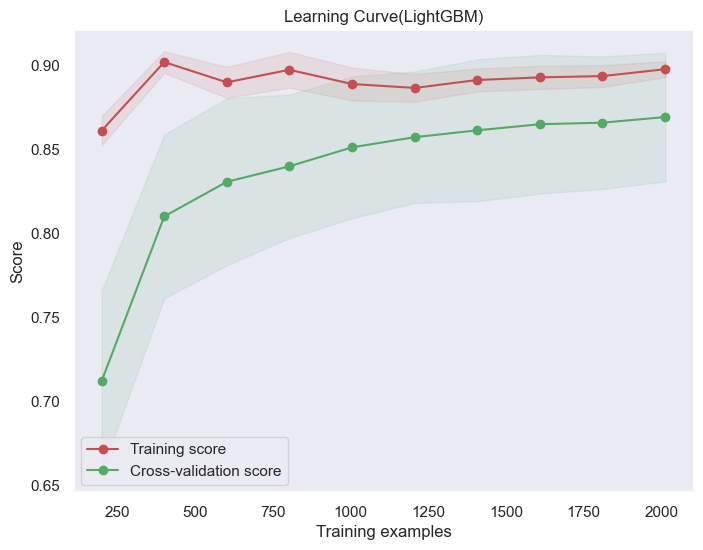

In [72]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=lgbm_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve(LightGBM)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [37]:
# Save the trained model to a file
dump(lgbm_clf, 'lgbm_model.joblib')

['lgbm_model.joblib']

# KNN

In [38]:
# Default params
knn_params = {
    'n_neighbors': [3],
    'weights': ['uniform'],
    'p': [2]
}

knn_clf = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2)

cross_validate(X_train, y_train, knn_clf)
knn_clf.fit(X_train, y_train)

Fold 0 	 auc: 0.6031797534068786
Fold 1 	 auc: 0.6996539043910881
Fold 2 	 auc: 0.6698031581224313
Fold 3 	 auc: 0.5499675535366646
Fold 4 	 auc: 0.6838632922344797
Fold 5 	 auc: 0.6108587497296128
Fold 6 	 auc: 0.6560379918588873
Fold 7 	 auc: 0.6689280868385347
Fold 8 	 auc: 0.6867933061962913
Fold 9 	 auc: 0.601763907734057
Avg AUC: 0.6430849704048925


KNeighborsClassifier(n_neighbors=3)

In [39]:
def objective(trial):
    knn_params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 15),
        "weights": trial.suggest_categorical("weights", ['uniform', 'distance']),
        "p": trial.suggest_categorical("p", [1, 2, 3])
    }

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_scores = []
    all_recalls = []

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        knn_clf = KNeighborsClassifier(**knn_params)
        knn_clf.fit(X_tr, y_tr)

        y_pred = knn_clf.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        #recall_value = recall_score(y_val, y_pred)
        
        all_scores.append(auc)
        #all_recalls.append(recall_value)

    avg_auc = np.mean(all_scores)
    #avg_recall = np.mean(all_recalls)

    return avg_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Avg_roc_auc_score: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
knn_clf = KNeighborsClassifier(**best_params)
knn_clf.fit(X_train, y_train)

[I 2023-05-07 10:57:13,114] A new study created in memory with name: no-name-5e32946a-bdb8-4085-97b7-9109561d805b
[I 2023-05-07 10:57:15,837] Trial 0 finished with value: 0.6735846459402592 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 3}. Best is trial 0 with value: 0.6735846459402592.
[I 2023-05-07 10:57:18,528] Trial 1 finished with value: 0.6848214461290386 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 3}. Best is trial 1 with value: 0.6848214461290386.
[I 2023-05-07 10:57:21,216] Trial 2 finished with value: 0.7030765146599022 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 3}. Best is trial 2 with value: 0.7030765146599022.
[I 2023-05-07 10:57:21,313] Trial 3 finished with value: 0.7426813560655223 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.7426813560655223.
[I 2023-05-07 10:57:24,039] Trial 4 finished with value: 0.6954348809313118 and parameters: {'n_neighbors': 9, 'weights': 

Best trial:
  Avg_roc_auc_score: 0.7573668220164003
  Params: 
    n_neighbors: 9
    weights: distance
    p: 1


KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')

In [40]:
knn_pred = knn_clf.predict(X_test)

print("Accuracy_value: ", accuracy_score(y_test, knn_pred))
print("f1_score_value: ", f1_score(y_test, knn_pred))
print("recall_value: ", recall_score(y_test, knn_pred))
print("roc_auc_score: ", roc_auc_score(y_test, knn_pred))

Accuracy_value:  0.9142857142857143
f1_score_value:  0.14285714285714285
recall_value:  0.08
roc_auc_score:  0.5380392156862746


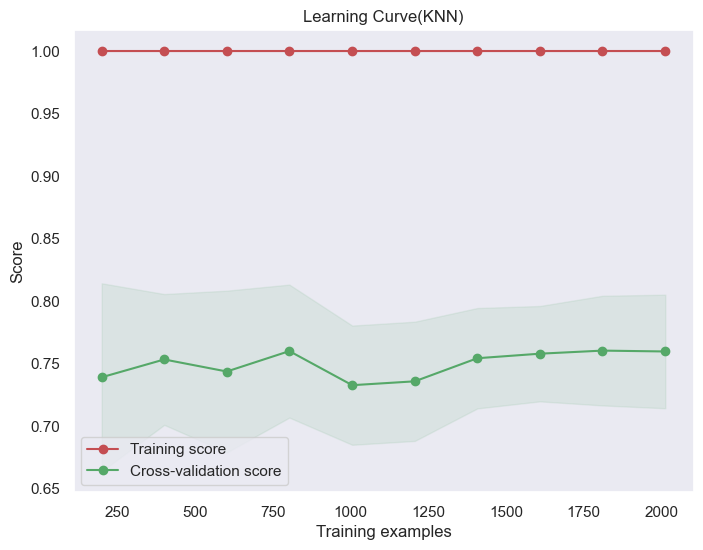

In [73]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve(KNN)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [41]:
# Save the trained model to a file
dump(knn_clf, 'knn_model.joblib')

['knn_model.joblib']

# Logistic Regression Classifier

In [42]:
lr_params = {
    'penalty': 'l2',
    'dual': False,
    'tol': 0.0001,
    'C': 1.0,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'class_weight': None,
    'random_state': None,
    'solver': 'lbfgs',
    'max_iter': 100,
    'multi_class': 'auto',
    'verbose': 0,
    'warm_start': False,
    'n_jobs': None,
    'l1_ratio': None
}

lr_clf = LogisticRegression(**lr_params)
cross_validate(X_train, y_train, lr_clf)
lr_clf.fit(X_train, y_train)

Fold 0 	 auc: 0.8382003028336578
Fold 1 	 auc: 0.8671858100800346
Fold 2 	 auc: 0.8555050832792559
Fold 3 	 auc: 0.8070516980315813
Fold 4 	 auc: 0.8247890979883192
Fold 5 	 auc: 0.8985507246376812
Fold 6 	 auc: 0.9145183175033921
Fold 7 	 auc: 0.8274536408864768
Fold 8 	 auc: 0.8995929443690638
Fold 9 	 auc: 0.8561736770691994
Avg AUC: 0.8589021296678663


LogisticRegression()

In [43]:
def objective(trial):
    # Define the hyperparameters to be tuned by Optuna
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'C': trial.suggest_loguniform('C', 1e-4, 100),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    }
    
    # Train and evaluate the logistic regression model using cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_scores = []
    all_recalls = []
    
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model = LogisticRegression(**params)
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        #recall_value = recall_score(y_val, y_pred)
        all_scores.append(auc)
        #all_recalls.append(recall_value)
        
    #avg_recall = np.mean(all_recalls)
    avg_auc = np.mean(all_scores)
    
    return avg_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Avg_roc_auc_score: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
lr_clf = LogisticRegression(**best_params)
lr_clf.fit(X_train, y_train)

[I 2023-05-07 10:57:27,864] A new study created in memory with name: no-name-7e9c4055-df1d-4af9-b8ab-b1e265ce3daa
[I 2023-05-07 10:57:27,936] Trial 0 finished with value: 0.7999360902994906 and parameters: {'penalty': 'l2', 'C': 0.0022932807996588096, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7999360902994906.
[I 2023-05-07 10:57:28,071] Trial 1 finished with value: 0.8586405915088589 and parameters: {'penalty': 'l2', 'C': 16.14507191615627, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 1 with value: 0.8586405915088589.
[I 2023-05-07 10:57:28,350] Trial 2 finished with value: 0.7998820128605982 and parameters: {'penalty': 'l2', 'C': 0.00030328882369830615, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 1 with value: 0.8586405915088589.
[I 2023-05-07 10:57:28,536] Trial 3 finished with value: 0.797772992743791 and parameters: {'penalty': 'l2', 'C': 0.00013233318646265144, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 1 wi

Best trial:
  Avg_roc_auc_score: 0.8595972705641751
  Params: 
    penalty: l2
    C: 0.45201271460956494
    fit_intercept: True
    solver: liblinear


LogisticRegression(C=0.45201271460956494, solver='liblinear')

In [44]:
lr_pred = lr_clf.predict(X_test)

print("Accuracy_value: ", accuracy_score(y_test, lr_pred))
print("f1_score_value: ", f1_score(y_test, lr_pred))
print("recall_value: ", recall_score(y_test, lr_pred))
print("roc_auc_score: ", roc_auc_score(y_test, lr_pred))

Accuracy_value:  0.9303571428571429
f1_score_value:  0.4799999999999999
recall_value:  0.36
roc_auc_score:  0.6731372549019607


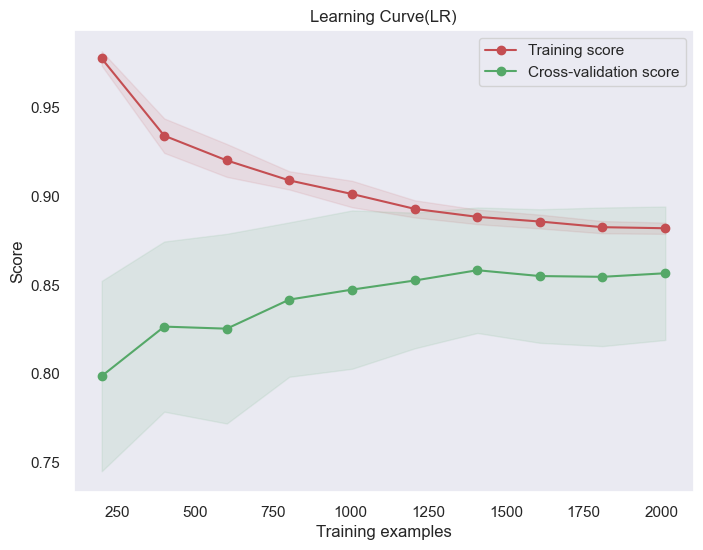

In [74]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=lr_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve(LR)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [45]:
# Save the trained model to a file
dump(lr_clf, 'lr_model.joblib')

['lr_model.joblib']

# Random Forest

In [46]:
rf_params = { 'n_estimators': 100,
              'criterion': 'gini',
              'max_depth': 10,
              'min_samples_split': 2,
              'min_samples_leaf': 1,
              'max_features': 'auto',
              'bootstrap': True,
              'min_impurity_decrease': 0.0,  
              'random_state': 42,
              'n_jobs': -1
             }

rf_clf = RandomForestClassifier(**rf_params)
cross_validate(X_train, y_train, rf_clf)
rf_clf.fit(X_train, y_train)

Fold 0 	 auc: 0.8301968418775687
Fold 1 	 auc: 0.8291152930997188
Fold 2 	 auc: 0.863724853990915
Fold 3 	 auc: 0.7769846420073545
Fold 4 	 auc: 0.8669695003244646
Fold 5 	 auc: 0.9149902660609993
Fold 6 	 auc: 0.9224332881049299
Fold 7 	 auc: 0.8629579375848033
Fold 8 	 auc: 0.8717774762550882
Fold 9 	 auc: 0.8349163274536409
Avg AUC: 0.8574066426759483


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [47]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 5, 50, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    bootstrap = True
    oob_score = False
    random_state = 42
    n_jobs = -1
   
    rf_params = {
        'n_estimators': n_estimators,
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'bootstrap': bootstrap,
        'oob_score': oob_score,
        'random_state': random_state,
        'n_jobs': n_jobs
    }
    
    model = RandomForestClassifier(**rf_params)
    
    skf = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)
    all_scores = []
    all_recalls = []

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)

        y_pred = model.predict_proba(X_val)[:, 1]
        #y_pred = (model.predict_proba(X_val)[:, 1] > 0.5).astype(int)

        auc = roc_auc_score(y_val, y_pred)
        #recall_value = recall_score(y_val, y_pred)

        all_scores.append(auc)
        #all_recalls.append(recall_value)

    avg_auc = np.mean(all_scores)
    #avg_recall = np.mean(all_recalls)

    return avg_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Avg_roc_auc_score: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = study.best_params
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

[I 2023-05-07 10:57:31,712] A new study created in memory with name: no-name-bf069405-7cec-4a8b-8a12-1ab283872551
[I 2023-05-07 10:58:12,442] Trial 0 finished with value: 0.8707018292682928 and parameters: {'n_estimators': 600, 'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8707018292682928.
[I 2023-05-07 10:58:19,964] Trial 1 finished with value: 0.87155 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 35, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.87155.
[I 2023-05-07 10:58:43,528] Trial 2 finished with value: 0.8729329268292684 and parameters: {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.8729329268292684.
[I 2023-05-07 10:59:26,518] Trial 3 finished with value: 0.8693256097560976 and parame

Best trial:
  Avg_roc_auc_score: 0.8729329268292684
  Params: 
    n_estimators: 300
    criterion: entropy
    max_depth: 50
    min_samples_split: 10
    min_samples_leaf: 3
    max_features: log2


RandomForestClassifier(criterion='entropy', max_depth=50, max_features='log2',
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=300)

In [48]:
rf_pred = rf_clf.predict(X_test)

print("Accuracy_value: ", accuracy_score(y_test, rf_pred))
print("f1_score_value: ", f1_score(y_test, rf_pred))
print("recall_value: ", recall_score(y_test, rf_pred))
print("roc_auc_score: ", roc_auc_score(y_test, rf_pred))

Accuracy_value:  0.9267857142857143
f1_score_value:  0.32786885245901637
recall_value:  0.2
roc_auc_score:  0.5990196078431372


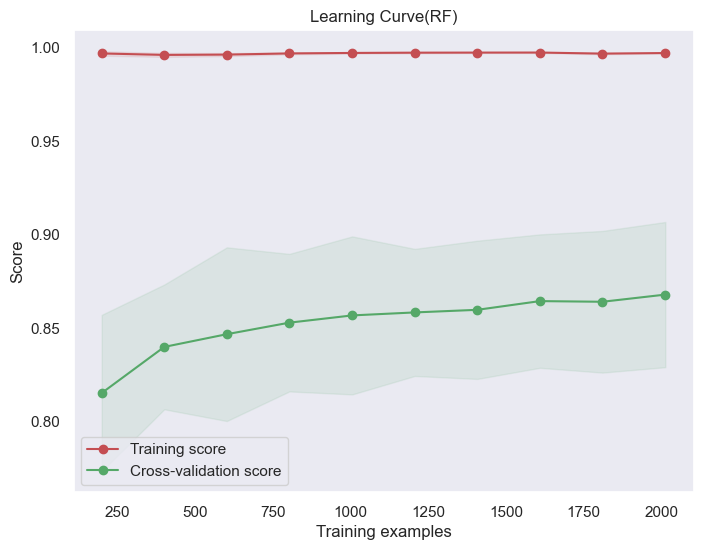

In [75]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve(RF)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [49]:
# Save the trained model to a file
dump(rf_clf, 'rf_model.joblib')

['rf_model.joblib']

# Suport Vector Machine

In [50]:
svm_params = {'C': 1.0,
              'kernel': 'rbf',
              'degree': 3,
              'gamma': 'scale',
              'coef0': 0.0,
              'shrinking': True,
              'probability': True,
              'tol': 0.001,
              'cache_size': 200,
              'class_weight': None,
              'verbose': False,
              'max_iter': -1,
              'decision_function_shape': 'ovr',
              'break_ties': False,
              'random_state': None}

svm_clf = SVC(**svm_params)
cross_validate(X_train, y_train, svm_clf)
svm_clf.fit(X_train, y_train)

Fold 0 	 auc: 0.7700627298291153
Fold 1 	 auc: 0.8756218905472637
Fold 2 	 auc: 0.8831927319922128
Fold 3 	 auc: 0.7971014492753623
Fold 4 	 auc: 0.8133246809431105
Fold 5 	 auc: 0.8312783906554185
Fold 6 	 auc: 0.8950701040253278
Fold 7 	 auc: 0.8215739484396201
Fold 8 	 auc: 0.8959746720940751
Fold 9 	 auc: 0.8541383989145183
Avg AUC: 0.8437338996716024


SVC(probability=True)

In [51]:
svm_pred = svm_clf.predict(X_test)

print("Accuracy_value: ", accuracy_score(y_test, svm_pred))
print("f1_score_value: ", f1_score(y_test, svm_pred))
print("recall_value: ", recall_score(y_test, svm_pred))
print("roc_auc_score: ", roc_auc_score(y_test, svm_pred))

Accuracy_value:  0.9107142857142857
f1_score_value:  0.0
recall_value:  0.0
roc_auc_score:  0.5


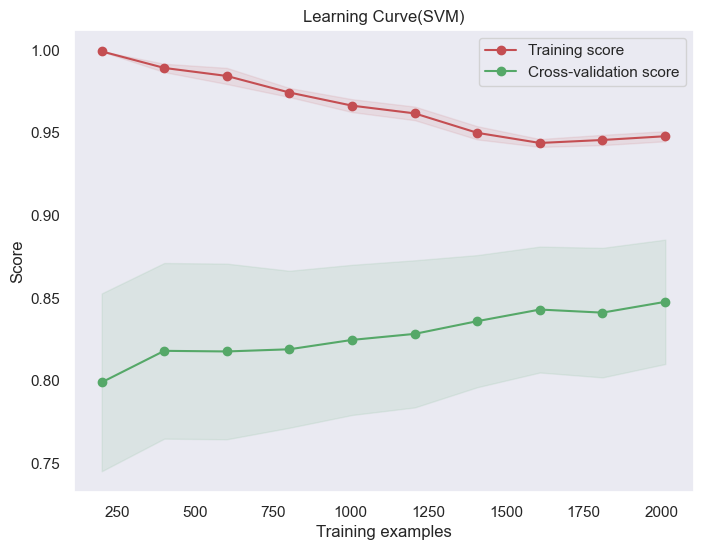

In [71]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=svm_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve(SVM)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [52]:
# Save the trained model to a file
dump(svm_clf, 'svm_model.joblib')

['svm_model.joblib']

In [53]:
# def objective(trial):
#     # Define the hyperparameters to be tuned by Optuna
#     params = {
#         'C': trial.suggest_loguniform('C', 1e-4, 100),
#         'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
#         'gamma': trial.suggest_loguniform('gamma', 1e-4, 100),
#         'degree': trial.suggest_int('degree', 2, 5),
#         'coef0': trial.suggest_uniform('coef0', -1, 1)
#     }
    
#     # Train and evaluate the SVC model using cross-validation
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     all_scores = []
    
#     for fold_id, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
#         X_tr, X_val = X_train[train_idx], X_train[val_idx]
#         y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
#         model = SVC(**params, probability=True)
#         model.fit(X_tr, y_tr)
#         y_pred = model.predict_proba(X_val)[:, 1]
#         auc = roc_auc_score(y_val, y_pred)
#         all_scores.append(auc)
#     avg_auc = np.mean(all_scores)

#     return avg_auc

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# print("Best trial:")
# trial = study.best_trial
# print("  Avg_roc_auc_score: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# best_params = trial.params
# svm_clf = SVC(**best_params, probability=True)
# svm_clf.fit(X_train, y_train)

# AdaBoost Classifier

In [54]:
from sklearn.ensemble import AdaBoostClassifier

ada_params = {'n_estimators': 50,
                  'learning_rate': 1.0,
                  'algorithm': 'SAMME.R',
                  'random_state': 42}

ada_clf = AdaBoostClassifier(**ada_params)
cross_validate(X_train, y_train, ada_clf)
ada_clf.fit(X_train, y_train)

Fold 0 	 auc: 0.8390655418559376
Fold 1 	 auc: 0.8513951979234263
Fold 2 	 auc: 0.8455548345230369
Fold 3 	 auc: 0.8691325978801644
Fold 4 	 auc: 0.8074843175427211
Fold 5 	 auc: 0.8924940514817218
Fold 6 	 auc: 0.8471279963817278
Fold 7 	 auc: 0.886250565355043
Fold 8 	 auc: 0.8950701040253279
Fold 9 	 auc: 0.882858435097241
Avg AUC: 0.8616433642066348


AdaBoostClassifier(random_state=42)

In [55]:
def objective(trial):
    
    # Define the hyperparameters to be tuned by Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R'])
    }
    
    # Train and evaluate the AdaBoostClassifier model using cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_scores = []
    all_recalls = []
    
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model = AdaBoostClassifier(**params)
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        #recall_value = recall_score(y_val, y_pred)
        all_scores.append(auc)
        #all_recalls.append(recall_value)
    #avg_recall = np.mean(all_recalls)
    avg_auc = np.mean(all_scores)
    
    return avg_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Avg_roc_auc_score: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
ada_clf = AdaBoostClassifier(**best_params)
ada_clf.fit(X_train, y_train)

[I 2023-05-07 11:02:02,398] A new study created in memory with name: no-name-4f70eb64-2891-4148-b83f-98f72c9ac227
[I 2023-05-07 11:02:03,897] Trial 0 finished with value: 0.810873498122038 and parameters: {'n_estimators': 62, 'learning_rate': 0.0496112290557376, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.810873498122038.
[I 2023-05-07 11:02:07,487] Trial 1 finished with value: 0.8751966452323364 and parameters: {'n_estimators': 150, 'learning_rate': 0.19163705657744576, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.8751966452323364.
[I 2023-05-07 11:02:10,683] Trial 2 finished with value: 0.8732911529309971 and parameters: {'n_estimators': 121, 'learning_rate': 0.08290885397195111, 'algorithm': 'SAMME.R'}. Best is trial 1 with value: 0.8751966452323364.
[I 2023-05-07 11:02:14,764] Trial 3 finished with value: 0.8484484691168662 and parameters: {'n_estimators': 171, 'learning_rate': 0.04118659854191082, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.87519664523233

Best trial:
  Avg_roc_auc_score: 0.8776920732306845
  Params: 
    n_estimators: 111
    learning_rate: 0.1644233631495588
    algorithm: SAMME.R


AdaBoostClassifier(learning_rate=0.1644233631495588, n_estimators=111)

In [56]:
ada_pred = ada_clf.predict(X_test)

print("Accuracy_value: ", accuracy_score(y_test, ada_pred))
print("f1_score_value: ", f1_score(y_test, ada_pred))
print("recall_value: ", recall_score(y_test, ada_pred))
print("roc_auc_score: ", roc_auc_score(y_test, ada_pred))

Accuracy_value:  0.9392857142857143
f1_score_value:  0.48484848484848486
recall_value:  0.32
roc_auc_score:  0.66


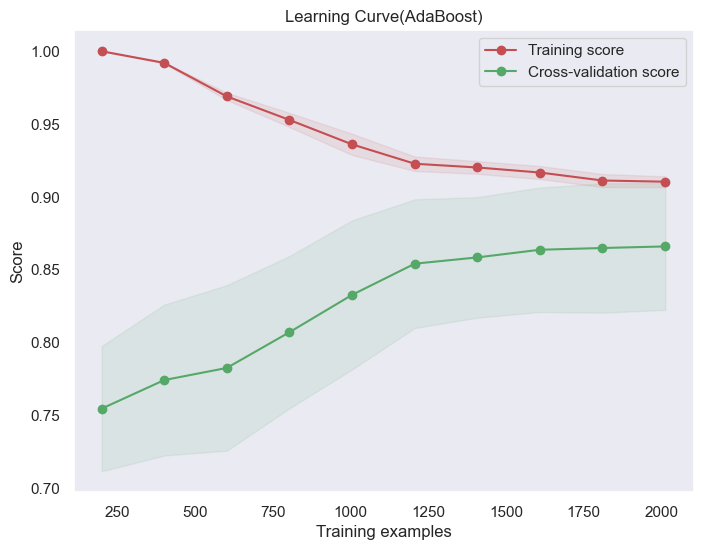

In [70]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=ada_clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Learning Curve(AdaBoost)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [57]:
# Save the trained model to a file
dump(ada_clf, 'ada_model.joblib')

['ada_model.joblib']

# Disagreement Heatmap

In [76]:
# Define the trained models
models = [rf_clf, lgbm_clf, lr_clf, xgb_clf, knn_clf, svm_clf, ada_clf]

# Define the prediction function for a single model
def predict_single_model(X, model):
    y_pred = model.predict(X)
    return y_pred

# Define the disagreement function between two models
def disagreement(y_pred1, y_pred2):
    return np.sum(y_pred1 != y_pred2)

# Compute the pairwise disagreements between all models
disagreements = np.zeros((len(models), len(models)))
for i in range(len(models)):
    for j in range(i+1, len(models)):
        y_pred1 = predict_single_model(X_train, models[i])
        y_pred2 = predict_single_model(X_train, models[j])
        disagreements[i][j] = disagreement(y_pred1, y_pred2)
        disagreements[j][i] = disagreements[i][j]

# Compute the disagreement scores for each model
disagreement_scores = np.sum(disagreements, axis=1)

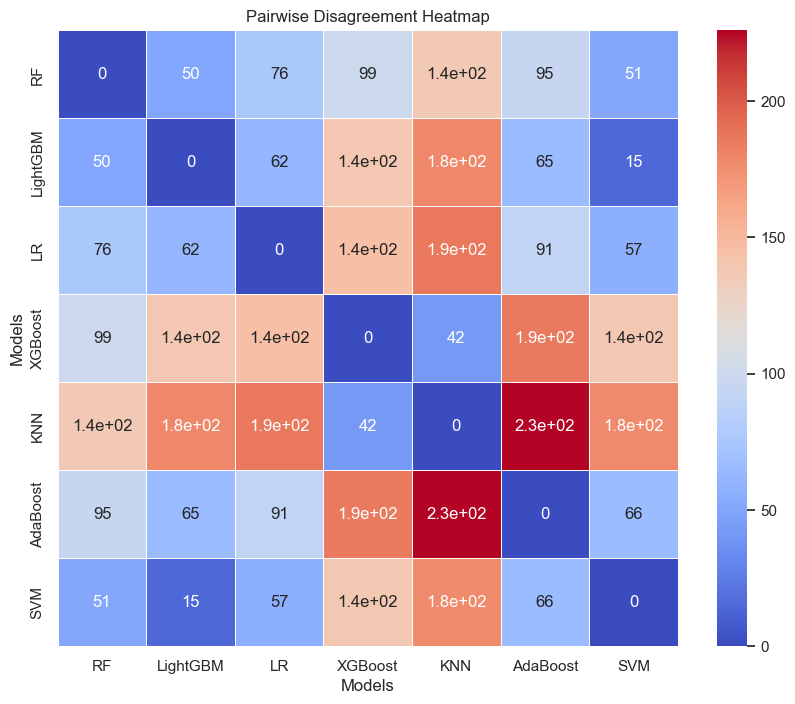

In [77]:
# Define the names of the models
model_names = ['RF', 'LightGBM', 'LR', 'XGBoost', 'KNN', 'AdaBoost','SVM']

# Plot the heatmap
sns.set()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(disagreements, cmap="coolwarm", annot=True, linewidths=0.5, ax=ax)

# Replace the tick labels with the model names
ax.set_xticklabels(model_names)
ax.set_yticklabels(model_names)

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Models')
ax.set_title('Pairwise Disagreement Heatmap')
plt.show()

# Super Learner for Classification

In [78]:
# create a list of base-models
def get_models():
    models_list = list()
    models_list.append(LogisticRegression(solver='liblinear'))
    models_list.append(XGBClassifier())
    models_list.append(KNeighborsClassifier())
    models_list.append(LGBMClassifier())
    models_list.append(RandomForestClassifier(n_estimators=10))
    models_list.append(AdaBoostClassifier())
    models_list.append(SVC(gamma='scale', probability=True))
    
    #models.append(GaussianNB())
    #models.append(BaggingClassifier(n_estimators=10))
    #models.append(ExtraTreesClassifier(n_estimators=10))
    return models_list

In [79]:
# from sklearn.ensemble import StackingClassifier
# # rf_clf, lgbm_clf, lr_clf, xgb_clf, knn_clf, svm_clf, ada_clf
# model_list = [
#     #('ann',ann),
#     ('rf',rf_clf),
#    # ('lgbm',lgbm_clf),
#     ('logistic_regrresion',lr_clf),
#     ('xgb',xgb_clf),
#     ('knn',knn_clf),
#     ('svm',svm_clf),
#     ('ada',ada_clf) ]

# # define the meta-classifier
# meta_clf = LogisticRegression()

# # Build stack model
# stack_model = StackingClassifier(estimators=model_list, final_estimator=LogisticRegression())

# stack_model.fit(X_train, y_train)

# yhat = stack_model.predict(X_test)

# stack_model.score(X_test,y_test)
# print('Stack Model: %.3f' % (accuracy_score(y_test, yhat) * 100))

In [80]:
# import pickle
# # Save the trained model to a file

# with open('stack_model_ensemble_model.pickle', 'wb') as f:
#     pickle.dump(stack_model, f)


# Super Learner for Classification With the ML-Ensemble Library

In [81]:
# create the super learner
def get_super_learner(X):
    ensemble = SuperLearner(scorer=accuracy_score, folds=10, shuffle=True, sample_size=len(X))

    # add base models
    models = get_models()
    ensemble.add(models)

    # add the meta model
    ensemble.add_meta(LogisticRegression(solver='lbfgs'))
    return ensemble
 
# create the super learner
ensemble = get_super_learner(X_train)

# fit the super learner
ensemble.fit(X_train, y_train)
 
# summarize base learners
print(ensemble.data)

# make predictions on hold out set
yhat = ensemble.predict(X_test)
print('Super Learner: %.3f' % (accuracy_score(y_test, yhat) * 100))

# "ft-m" column shows the mean feature importance score
# "ft-s" column shows the standard deviation of the feature importance scores
# "pt-m" column shows the mean prediction time (in seconds)
# "pt-s" column shows the standard deviation of the prediction times

                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier           0.91     0.02  1.24  0.06  0.09  0.03
layer-1  kneighborsclassifier         0.90     0.02  0.01  0.00  0.05  0.01
layer-1  lgbmclassifier               0.92     0.01  1.79  1.04  0.00  0.00
layer-1  logisticregression           0.91     0.01  0.02  0.00  0.00  0.00
layer-1  randomforestclassifier       0.91     0.01  0.09  0.02  0.01  0.00
layer-1  svc                          0.90     0.01  0.66  0.08  0.02  0.00
layer-1  xgbclassifier                0.92     0.01  0.38  0.02  0.00  0.00

Super Learner: 93.750


In [82]:
print("Accuracy_value: ", accuracy_score(y_test, yhat))
print("f1_score_value: ", f1_score(y_test, yhat))
print("recall_value  : ", recall_score(y_test, yhat))

Accuracy_value:  0.9375
f1_score_value:  0.5333333333333333
recall_value  :  0.4


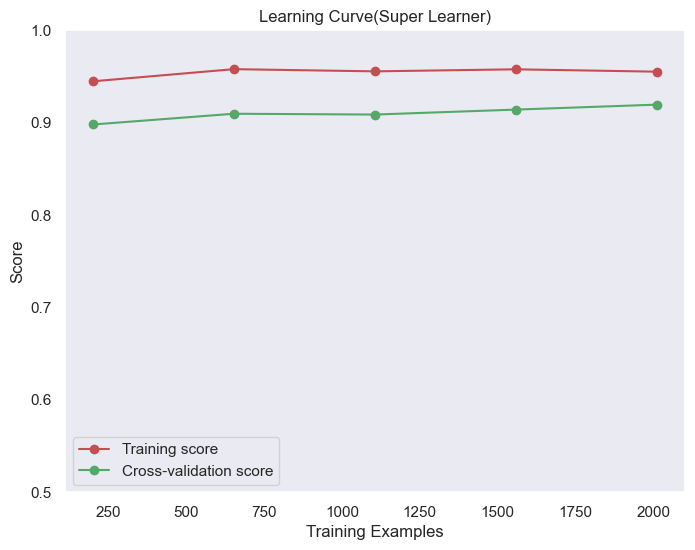

In [83]:
# calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(
    ensemble, X_train, y_train, cv=10, scoring='accuracy')

# plot the learning curve
plt.figure(figsize=(8, 6))
plt.title('Learning Curve(Super Learner)')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.grid()

# plot the mean training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
         label='Cross-validation score')

# add a legend
plt.legend(loc='best')

plt.show()


In [84]:
# Save the trained model to a file
dump(ensemble, 'super_learner_ensemble_model.joblib')

['super_learner_ensemble_model.joblib']

In [85]:
ensemble = joblib.load('super_learner_ensemble_model.joblib')

# Precision, Recall & F1 score

In [86]:
from sklearn.metrics import classification_report

# get classification report for each model
for model in models + [ensemble]:
    yhat = model.predict(X_test)
    report = classification_report(y_test, yhat)
    print(model.__class__.__name__)
    print(report)

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       510
           1       0.91      0.20      0.33        50

    accuracy                           0.93       560
   macro avg       0.92      0.60      0.64       560
weighted avg       0.93      0.93      0.90       560

LGBMClassifier
              precision    recall  f1-score   support

           0       0.94      1.00      0.96       510
           1       0.88      0.30      0.45        50

    accuracy                           0.93       560
   macro avg       0.91      0.65      0.71       560
weighted avg       0.93      0.93      0.92       560

LogisticRegression
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       510
           1       0.72      0.36      0.48        50

    accuracy                           0.93       560
   macro avg       0.83      0.67      0.72       560
weighted avg     

# AUC/ROC Curve

In [87]:
# predict probabilities
pred_prob1 = rf_clf.predict_proba(X_test)
pred_prob2 = lgbm_clf.predict_proba(X_test)
pred_prob3 = lr_clf.predict_proba(X_test)
pred_prob4 = xgb_clf.predict_proba(X_test)
pred_prob5 = knn_clf.predict_proba(X_test)
pred_prob6 = svm_clf.predict_proba(X_test)
pred_prob7 = ada_clf.predict_proba(X_test)
pred_prob8 = ensemble.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, pred_prob6[:,1], pos_label=1)
fpr7, tpr7, thresh7 = roc_curve(y_test, pred_prob7[:,1], pos_label=1)
#fpr8, tpr6, thresh6 = roc_curve(y_test, pred_prob6[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])
auc_score4 = roc_auc_score(y_test, pred_prob4[:,1])
auc_score5 = roc_auc_score(y_test, pred_prob5[:,1])
auc_score6 = roc_auc_score(y_test, pred_prob6[:,1])
auc_score7 = roc_auc_score(y_test, pred_prob7[:,1])

# print classifier name and AUC score
print("AUC_Scores")
print("")
print("Random Forest :", auc_score1)
print("LightGBM      :", auc_score2)
print("Logistic Regression:", auc_score3)
print("XGBoost       :", auc_score4)
print("KNN           :", auc_score5)
print("AdaBoost      :", auc_score6)
print("SVM           :", auc_score7)

AUC_Scores

Random Forest : 0.8869019607843137
LightGBM      : 0.8785098039215687
Logistic Regression: 0.8848627450980392
XGBoost       : 0.8983529411764707
KNN           : 0.7631764705882352
AdaBoost      : 0.8832941176470589
SVM           : 0.868549019607843


In [88]:
# predict probabilities
pred_prob1 = rf_clf.predict_proba(X_test)
pred_prob2 = lgbm_clf.predict_proba(X_test)
pred_prob3 = lr_clf.predict_proba(X_test)
pred_prob4 = xgb_clf.predict_proba(X_test)
pred_prob5 = knn_clf.predict_proba(X_test)
pred_prob6 = svm_clf.predict_proba(X_test)
pred_prob7 = ada_clf.predict_proba(X_test)
pred_prob8 = ensemble.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, pred_prob6[:,1], pos_label=1)
fpr7, tpr7, thresh7 = roc_curve(y_test, pred_prob7[:,1], pos_label=1)
#fpr8, tpr6, thresh6 = roc_curve(y_test, pred_prob6[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])
auc_score4 = roc_auc_score(y_test, pred_prob4[:,1])
auc_score5 = roc_auc_score(y_test, pred_prob5[:,1])
auc_score6 = roc_auc_score(y_test, pred_prob6[:,1])
auc_score7 = roc_auc_score(y_test, pred_prob7[:,1])

# print classifier name and AUC score
print("AUC_Scores")
print("")
print("Random Forest :", auc_score1)
print("LightGBM      :", auc_score2)
print("Logistic Regression:", auc_score3)
print("XGBoost       :", auc_score4)
print("KNN           :", auc_score5)
print("AdaBoost      :", auc_score6)
print("SVM           :", auc_score7)

AUC_Scores

Random Forest : 0.8869019607843137
LightGBM      : 0.8785098039215687
Logistic Regression: 0.8848627450980392
XGBoost       : 0.8983529411764707
KNN           : 0.7631764705882352
AdaBoost      : 0.8832941176470589
SVM           : 0.868549019607843


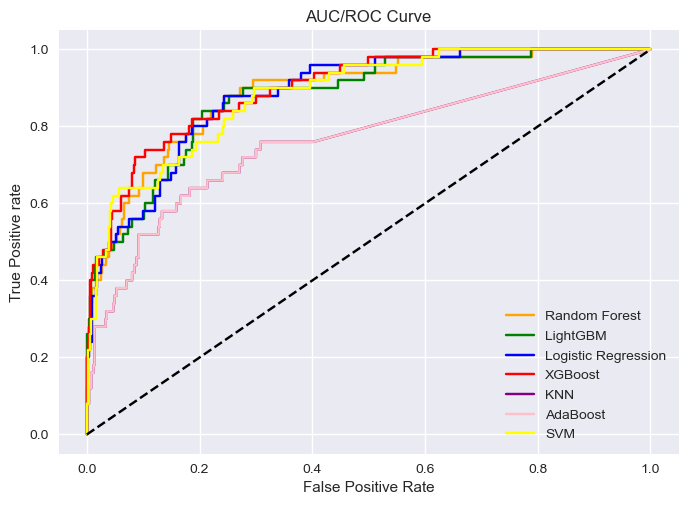

In [89]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='-',color='orange', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='-',color='green', label='LightGBM')
plt.plot(fpr3, tpr3, linestyle='-',color='blue', label='Logistic Regression')
plt.plot(fpr4, tpr4, linestyle='-',color='red', label='XGBoost')
plt.plot(fpr5, tpr5, linestyle='-',color='purple', label='KNN')
plt.plot(fpr5, tpr5, linestyle='-',color='pink', label='AdaBoost')
plt.plot(fpr6, tpr6, linestyle='-',color='yellow', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')

# title
plt.title('AUC/ROC Curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

# Making Submission